In [ ]:
# ===============================
# Librairies
# ===============================
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [61]:
# ===============================
# Load a real time series
# ===============================
def load_data_from_csv(filepath):
    # Load CSV without header
    df = pd.read_csv(filepath, header=None)
    # Combine first two rows into a single header
    header1 = df.iloc[0].fillna("")  # market symbols
    header2 = df.iloc[1].fillna("")  # OHLCV etc
    # Create new column names
    new_header = []
    for h1, h2 in zip(header1, header2):
        if h1 != "":
            new_header.append(f"{h1}_{h2}" if h2 != "" else h1)
        else:
            new_header.append(h2)
    # Drop first two rows from the data
    df = df[2:]
    df.columns = new_header
    df = df.reset_index(drop=True)
    # Optional: remove fully empty columns
    df = df.dropna(axis=1, how='all')
    return df

df_load = load_data_from_csv("../data/Stock_Market_Initial_Data.csv")
df_load

/var/folders/8j/y46wyjvx641clg_t_cq0ggfc0000gn/T/ipykernel_80844/4198978970.py:6: DtypeWarning: Columns (1,2,3,4,5,6,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,29,30,31,32,33,34,36,37,38,39,40,41,43,44,45,46,47,48,50,51,52,53,54,55,57,58,59,60,61,62,64,65,66,67,68,69,71,72,73,74,75,76,78,79,80,81,82,83,85,86,87,88,89,90,92,93,94,95,96,97,99,100,101,102,103,104,106,107,108,109,110,111,113,114,115,116,117,118,120,121,122,123,124,125,127,128,129,130,131,132,134,135,136,137,138,139,141,142,143,144,145,146,148,149,150,151,152,153,155,156,157,158,159,160,162,163,164,165,166,167,169,170,171,172,173,174,176,177,178,179,180,181,183,184,185,186,187,188,190,191,192,193,194,195,197,198,199,200,201,202,204,205,206,207,208,209,211,212,213,214,215,216,218,219,220,221,222,223,225,226,227,228,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, header=None)


,Date,^GSPC_High,Low,Open,Close,Volume,Adj Close,^IXIC_High,Low,Open,...,Open,Close,Volume,Adj Close,^JN0U.JO_High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.9500122,740.7399902,753.8499756,740.7399902,399760000,740.7399902,1291.880005,1285.449951,1289.23999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/2/1997,742.8099976,729.5499878,740.7399902,737.0100098,463230000,737.0100098,1293.630005,1272.339966,1292.650024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/3/1997,748.2399902,737.0100098,737.0100098,748.0300293,452970000,748.0300293,1310.839966,1280.699951,1288.02002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/6/1997,753.3099976,743.8200073,748.0300293,747.6500244,531350000,747.6500244,1321.469971,1310.630005,1314.339966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/7/1997,753.2600098,742.1799927,747.6500244,753.2299805,538220000,753.2299805,1327.819946,1312.079956,1316.910034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4899000000,3759.689941,10993.24023,10522.90039,10885.00977,...,NaN,NaN,NaN,NaN,3640.830078,3566.639893,3602.090088,3573.790039,0.0,3573.790039
6505,11/3/2022,3750.590088,3698.149902,3733.25,3719.889893,4625290000,3719.889893,10486.00977,10319.54004,10399.4502,...,NaN,NaN,NaN,NaN,3557.22998,3431.080078,3557.0,3474.129883,0.0,3474.129883
6506,11/4/2022,3796.340088,3708.840088,3766.97998,3770.550049,0,3770.550049,10553.62988,10262.92969,10548.13965,...,NaN,NaN,NaN,NaN,3765.290039,3497.070068,3498.77002,3751.629883,0.0,3751.629883
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4341620000,3806.800049,10587.95996,10428.91016,10516.94043,...,NaN,NaN,NaN,NaN,3826.070068,3695.27002,3749.379883,3815.75,0.0,3815.75


In [62]:
# ===============================
# Function to extract market data for a specific index from the CSV file
# ===============================
def extract_market_data(df, market_name):
    """
    Extract Date + OHLCV columns for a given market
    """
    df.columns = df.columns.str.strip()
    high_col_candidates = [c for c in df.columns if c.startswith(f"{market_name}_High")]
    if not high_col_candidates:
        raise ValueError(f"Column starting with {market_name}_High not found.")
    
    high_col = high_col_candidates[0]
    high_idx = df.columns.get_loc(high_col)
    
    # Date + next 6 columns (High, Low, Open, Close, Volume, Adj Close)
    cols_idx = [0] + list(range(high_idx, high_idx + 6))
    df_market = df.iloc[:, cols_idx].copy()
    df_market = df_market.reset_index(drop=True)
    
    # Rename columns for clarity
    df_market.columns = ["Date", "High", "Low", "Open", "Close", "Volume", "Adj Close"]
    df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]] = df_market[["High", "Low", "Open", "Close", "Volume", "Adj Close"]].astype(float)
    return df_market

# Example for ^GSPC
df_gspc = extract_market_data(df_load, "^GSPC")
df_gspc

,Date,High,Low,Open,Close,Volume,Adj Close
0,12/31/1996,753.950012,740.739990,753.849976,740.739990,3.997600e+08,740.739990
1,1/2/1997,742.809998,729.549988,740.739990,737.010010,4.632300e+08,737.010010
2,1/3/1997,748.239990,737.010010,737.010010,748.030029,4.529700e+08,748.030029
3,1/6/1997,753.309998,743.820007,748.030029,747.650024,5.313500e+08,747.650024
4,1/7/1997,753.260010,742.179993,747.650024,753.229981,5.382200e+08,753.229981
...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,3759.689941
6505,11/3/2022,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,3719.889893
6506,11/4/2022,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,3770.550049
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4.341620e+09,3806.800049


In [63]:
# ===============================
# Preprocess the data to add additional informations
# ===============================
def preprocess_data(df):
    """
    Full preprocessing for OHLCV financial data
    Adds trend, momentum, volatility, OHLC-based, volume, and temporal features
    """

    # 1. Temporal features (not useful for stock market datas)
    # dates = pd.to_datetime(df['Date'])
    # df['DayOfYear'] = dates.dt.dayofyear
    # df['Month'] = dates.dt.month
    # df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    # df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    # df['Sin_Month'] = np.sin(2 * np.pi * df['Month'] / 12)
    # df['Cos_Month'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 2. Price-based indicators
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

    # Momentum / Returns
    df['Daily_Return'] = df['Close'].pct_change()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Momentum_4'] = df['Close'] - df['Close'].shift(4)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Relative Strength / Momentum indicators
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    low14 = df['Close'].rolling(14).min()
    high14 = df['Close'].rolling(14).max()
    df['Stochastic_K'] = 100 * (df['Close'] - low14) / (high14 - low14)
    df['Stochastic_D'] = df['Stochastic_K'].rolling(3).mean()

    # Volatility indicators
    df['Volatility_10'] = df['Close'].rolling(10).std()
    df['Volatility_20'] = df['Close'].rolling(20).std()
    # df['ATR_14'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    # df['ATR_14'] = df['ATR_14'].rolling(14).mean()
    # df['Price_Range'] = df['High'] - df['Low']

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    df['Middle_Band'] = df['Close'].rolling(20).mean()
    df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(20).std() * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(20).std() * 2)
    df['BB_%B'] = (df['Close'] - df['Lower_Band']) / (df['Upper_Band'] - df['Lower_Band'])
    
    # OHLC-based features
    # df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    # df['Candle_Body'] = df['Close'] - df['Open']
    # df['Upper_Shadow'] = df['High'] - df[['Close', 'Open']].max(axis=1)
    # df['Lower_Shadow'] = df[['Close', 'Open']].min(axis=1) - df['Low']
    # df['Gap'] = df['Open'] - df['Close'].shift(1)
    # df['HL_Ratio'] = df['High'] / df['Low']
    # df['CO_Ratio'] = df['Close'] / df['Open']
    
    # Volume-based features
    # df['Volume_SMA_20'] = df['Volume'].rolling(20).mean()
    # df['Volume_SMA_50'] = df['Volume'].rolling(50).mean()
    # df['Volume_Change'] = df['Volume'].pct_change() # clip?? 
    # # Volume indicators
    # obv = [0]
    # for i in range(1, len(df)):
    #     if df['Close'][i] > df['Close'][i-1]:
    #         obv.append(obv[-1] + df['Volume'][i])
    #     elif df['Close'][i] < df['Close'][i-1]:
    #         obv.append(obv[-1] - df['Volume'][i])
    #     else:
    #         obv.append(obv[-1])
    # df['OBV'] = obv
    # df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    
    # Drop NaNs created by rolling/shift
    df.dropna(inplace=True)
    
    return df

df = preprocess_data(df_gspc)
df

,Date,High,Low,Open,Close,Volume,Adj Close,SMA_50,SMA_200,EMA_20,...,Stochastic_K,Stochastic_D,Volatility_10,Volatility_20,MACD,MACD_Signal,Middle_Band,Upper_Band,Lower_Band,BB_%B
199,10/14/1997,972.859985,961.869995,968.099976,970.280029,5.103300e+08,970.280029,938.981000,852.581201,958.358095,...,71.599293,67.558816,7.584680,12.519041,10.407819,9.965106,958.145999,983.184082,933.107917,0.742311
200,10/15/1997,970.280029,962.750000,970.280029,965.719971,5.053100e+08,965.719971,939.247999,853.706101,959.059226,...,54.089675,64.155401,6.149449,12.096009,9.714567,9.914998,959.281998,983.474016,935.089979,0.633060
201,10/16/1997,973.380005,950.770019,965.719971,955.250000,5.970100e+08,955.250000,939.146599,854.797301,958.696443,...,22.237663,49.308877,7.156083,11.808195,8.225503,9.577099,959.679999,983.296388,936.063609,0.406209
202,10/17/1997,955.229981,931.580017,955.229981,944.159973,6.249800e+08,944.159973,939.005999,855.777951,957.312017,...,0.000000,25.442446,10.673954,12.148212,6.080444,8.877768,959.362497,983.658921,935.066073,0.187145
203,10/20/1997,955.719971,941.429993,944.159973,955.609985,4.838800e+08,955.609985,939.447399,856.817751,957.149919,...,29.389132,17.208932,11.036199,12.145212,5.243941,8.151003,959.371497,983.661920,935.081073,0.422572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6504,11/2/2022,3894.439941,3758.679932,3852.899902,3759.689941,4.899000e+09,3759.689941,3821.862212,4101.216359,3777.747117,...,55.542589,77.476430,69.817359,103.336907,14.836953,-5.819047,3730.511011,3937.184825,3523.837196,0.570592
6505,11/3/2022,3750.590088,3698.149902,3733.250000,3719.889893,4.625290e+09,3719.889893,3813.444609,4097.152009,3772.236905,...,22.998069,54.800620,58.575029,103.307929,7.799778,-3.095282,3729.279504,3935.895362,3522.663647,0.477278
6506,11/4/2022,3796.340088,3708.840088,3766.979980,3770.550049,0.000000e+00,3770.550049,3804.873208,4093.591110,3772.076252,...,44.529925,41.023528,56.693756,101.461170,6.238702,-1.228485,3735.824011,3938.746350,3532.901672,0.585565
6507,11/7/2022,3813.949951,3764.699951,3780.709961,3806.800049,4.341620e+09,3806.800049,3799.856011,4090.635410,3775.383280,...,59.937097,42.488364,56.400715,98.275890,7.836278,0.584467,3745.544519,3942.096299,3548.992739,0.655825


In [64]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'SMA_50',
       'SMA_200', 'EMA_20', 'EMA_50', 'Daily_Return', 'Log_Return',
       'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
       'Volatility_10', 'Volatility_20', 'MACD', 'MACD_Signal', 'Middle_Band',
       'Upper_Band', 'Lower_Band', 'BB_%B'],
      dtype='object')

In [65]:
# ===============================
# Plotting different figures (optional)
# ===============================
"""
# Example: price and moving averages
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='orange')
plt.plot(df['Date'], df['SMA_200'], label='SMA 200', color='green')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Close Price & Moving Averages')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Daily Returns & Log Returns
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['Daily_Return'], label='Daily Return', color='purple')
plt.plot(df['Date'], df['Log_Return'], label='Log Return', color='brown')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Daily and Log Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# RSI & Momentum
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['RSI_14'], label='RSI 14', color='blue')
plt.plot(df['Date'], df['Momentum_4'], label='Momentum 4', color='orange')
plt.plot(df['Date'], df['Momentum_10'], label='Momentum 10', color='green')
plt.xlabel('Date')
plt.ylabel('Indicator Value')
plt.title('RSI & Momentum Indicators')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bollinger Bands
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.plot(df['Date'], df['Middle_Band'], label='Middle Band', color='orange')
plt.plot(df['Date'], df['Upper_Band'], label='Upper Band', color='green')
plt.plot(df['Date'], df['Lower_Band'], label='Lower Band', color='red')
plt.fill_between(df['Date'], df['Lower_Band'], df['Upper_Band'], color='gray', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bollinger Bands')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Volume & OBV
# plt.figure(figsize=(16, 4))
# plt.plot(df['Date'], df['Volume'], label='Volume', color='blue', alpha=0.5)
# plt.plot(df['Date'], df['OBV'], label='On-Balance Volume (OBV)', color='orange')
# plt.xlabel('Date')
# plt.ylabel('Volume')
# plt.title('Volume & OBV')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
"""

"\n# Example: price and moving averages\nplt.figure(figsize=(16, 6))\nplt.plot(df['Date'], df['Close'], label='Close', color='blue')\nplt.plot(df['Date'], df['SMA_50'], label='SMA 50', color='orange')\nplt.plot(df['Date'], df['SMA_200'], label='SMA 200', color='green')\nplt.plot(df['Date'], df['EMA_20'], label='EMA 20', color='red', linestyle='--')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.title('Close Price & Moving Averages')\nplt.legend()\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# Daily Returns & Log Returns\nplt.figure(figsize=(16, 4))\nplt.plot(df['Date'], df['Daily_Return'], label='Daily Return', color='purple')\nplt.plot(df['Date'], df['Log_Return'], label='Log Return', color='brown')\nplt.xlabel('Date')\nplt.ylabel('Returns')\nplt.title('Daily and Log Returns')\nplt.legend()\nplt.grid(True)\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n\n# RSI & Momentum\nplt.figure(figsize=(16, 4))\nplt.plot(df['Date'], df['RSI_14'], label='RS

In [66]:
# ===============================
# Drop unused columns and verify data consistency
# ===============================
df_ml = df.copy()

df_ml = df_ml.drop(columns=["Date", "Open", "High", "Low", "Volume", "Adj Close"], errors="ignore")   # Remove non-numeric column
df_ml = df_ml.select_dtypes(include=[np.number]).dropna()

In [67]:
df_ml.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,1800.652282,932.659447,676.530029,1161.087555,1386.919983,2139.174927,4796.560059
SMA_50,6310.0,1789.730290,924.097034,788.956798,1144.508906,1379.013998,2116.683249,4681.011611
SMA_200,6310.0,1752.257996,890.892172,852.581201,1143.284848,1365.271801,2065.261064,4496.905588
EMA_20,6310.0,1796.403606,928.832691,743.372703,1157.973185,1385.079533,2138.139713,4720.631447
EMA_50,6310.0,1789.489094,922.821415,792.835619,1143.127564,1377.612689,2122.922503,4663.258078
Daily_Return,6310.0,0.000296,0.012493,-0.119841,-0.005043,0.000608,0.006094,0.115800
Log_Return,6310.0,0.000217,0.012514,-0.127652,-0.005056,0.000608,0.006076,0.109572
Momentum_4,6310.0,1.780079,44.624213,-496.100097,-15.274979,4.370056,21.447449,325.150146
Momentum_10,6310.0,4.512685,68.080100,-732.020019,-19.777527,9.439972,33.947571,426.280030
RSI_14,6310.0,54.478211,15.875957,4.009865,42.755398,54.745423,65.604112,99.298813


In [68]:
df_ml.isna().sum()

Close            0
SMA_50           0
SMA_200          0
EMA_20           0
EMA_50           0
Daily_Return     0
Log_Return       0
Momentum_4       0
Momentum_10      0
RSI_14           0
Stochastic_K     0
Stochastic_D     0
Volatility_10    0
Volatility_20    0
MACD             0
MACD_Signal      0
Middle_Band      0
Upper_Band       0
Lower_Band       0
BB_%B            0
dtype: int64

In [69]:
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna()

In [70]:
df_ml.columns

Index(['Close', 'SMA_50', 'SMA_200', 'EMA_20', 'EMA_50', 'Daily_Return',
       'Log_Return', 'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K',
       'Stochastic_D', 'Volatility_10', 'Volatility_20', 'MACD', 'MACD_Signal',
       'Middle_Band', 'Upper_Band', 'Lower_Band', 'BB_%B'],
      dtype='object')

In [71]:
# ===============================
# Keep historical data for later recursive forecast sequences recalculations
# ===============================
df_raw_hist = df_gspc[['Close']].copy()
df_raw_hist = df_raw_hist.select_dtypes(include=[np.number]).dropna()
df_raw_hist = df_raw_hist.replace([np.inf, -np.inf], np.nan)
df_raw_hist = df_raw_hist.dropna()
df_raw_hist.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,1800.652282,932.659447,676.530029,1161.087555,1386.919983,2139.174927,4796.560059


In [72]:
# ===============================
# Scale price datas not to cause imbalance into the model
# ===============================
# 1. Volume columns
# no need now 

# 2. Price columns
price_cols = [
    # "High", "Low", "Open", "Adj Close",
    "SMA_50", "SMA_200", "EMA_20", "EMA_50",
    "Middle_Band", "Upper_Band", "Lower_Band" #,
    # "Typical_Price", "VWAP"
]
prices_scaler = RobustScaler()
df_ml[price_cols] = prices_scaler.fit_transform(df_ml[price_cols])

indicators_scalers = {}
indicators_cols = [
  'Daily_Return', 'Log_Return', 'Momentum_4', 'Momentum_10', 'RSI_14', 'Stochastic_K', 'Stochastic_D',
    'Volatility_10', 'Volatility_20', # 'ATR_14', 'Price_Range', 
    'MACD', 'MACD_Signal', 'BB_%B' #,
    # 'Candle_Body', 'Upper_Shadow', 'Lower_Shadow', 'Gap',
    # 'HL_Ratio', 'CO_Ratio'
]
for col in indicators_cols:
    indicators_scalers[col] = RobustScaler()
    df_ml[col] = indicators_scalers[col].fit_transform(df_ml[[col]])

close_scaler = RobustScaler()
df_ml["Close"] = close_scaler.fit_transform(df_ml[["Close"]])

In [73]:
df_ml.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Close,6310.0,0.423001,0.953554,-0.726305,-0.230892,0.000000e+00,0.769108,3.486028
SMA_50,6310.0,0.422472,0.950547,-0.606946,-0.241217,0.000000e+00,0.758783,3.396508
SMA_200,6310.0,0.419736,0.966285,-0.556078,-0.240773,-1.233144e-16,0.759227,3.396654
EMA_20,6310.0,0.419647,0.947627,-0.654692,-0.231702,0.000000e+00,0.768298,3.403046
EMA_50,6310.0,0.420370,0.941852,-0.596836,-0.239321,-1.160367e-16,0.760679,3.353401
Daily_Return,6310.0,-0.028039,1.121681,-10.814778,-0.507370,0.000000e+00,0.492630,10.342872
Log_Return,6310.0,-0.035063,1.124211,-11.522087,-0.508761,-4.865357e-18,0.491239,9.788698
Momentum_4,6310.0,-0.070528,1.215176,-13.628461,-0.534960,0.000000e+00,0.465040,8.735264
Momentum_10,6310.0,-0.091713,1.267194,-13.800999,-0.543833,0.000000e+00,0.456167,7.758759
RSI_14,6310.0,-0.011695,0.694829,-2.220499,-0.524757,1.554881e-16,0.475243,1.949930


In [74]:
# ===============================
# Prepare features and target variable for correlation heatmap
# ===============================
X = df_ml.drop(columns=["Date"], errors="ignore") # Features
y = df_ml["Close"] 

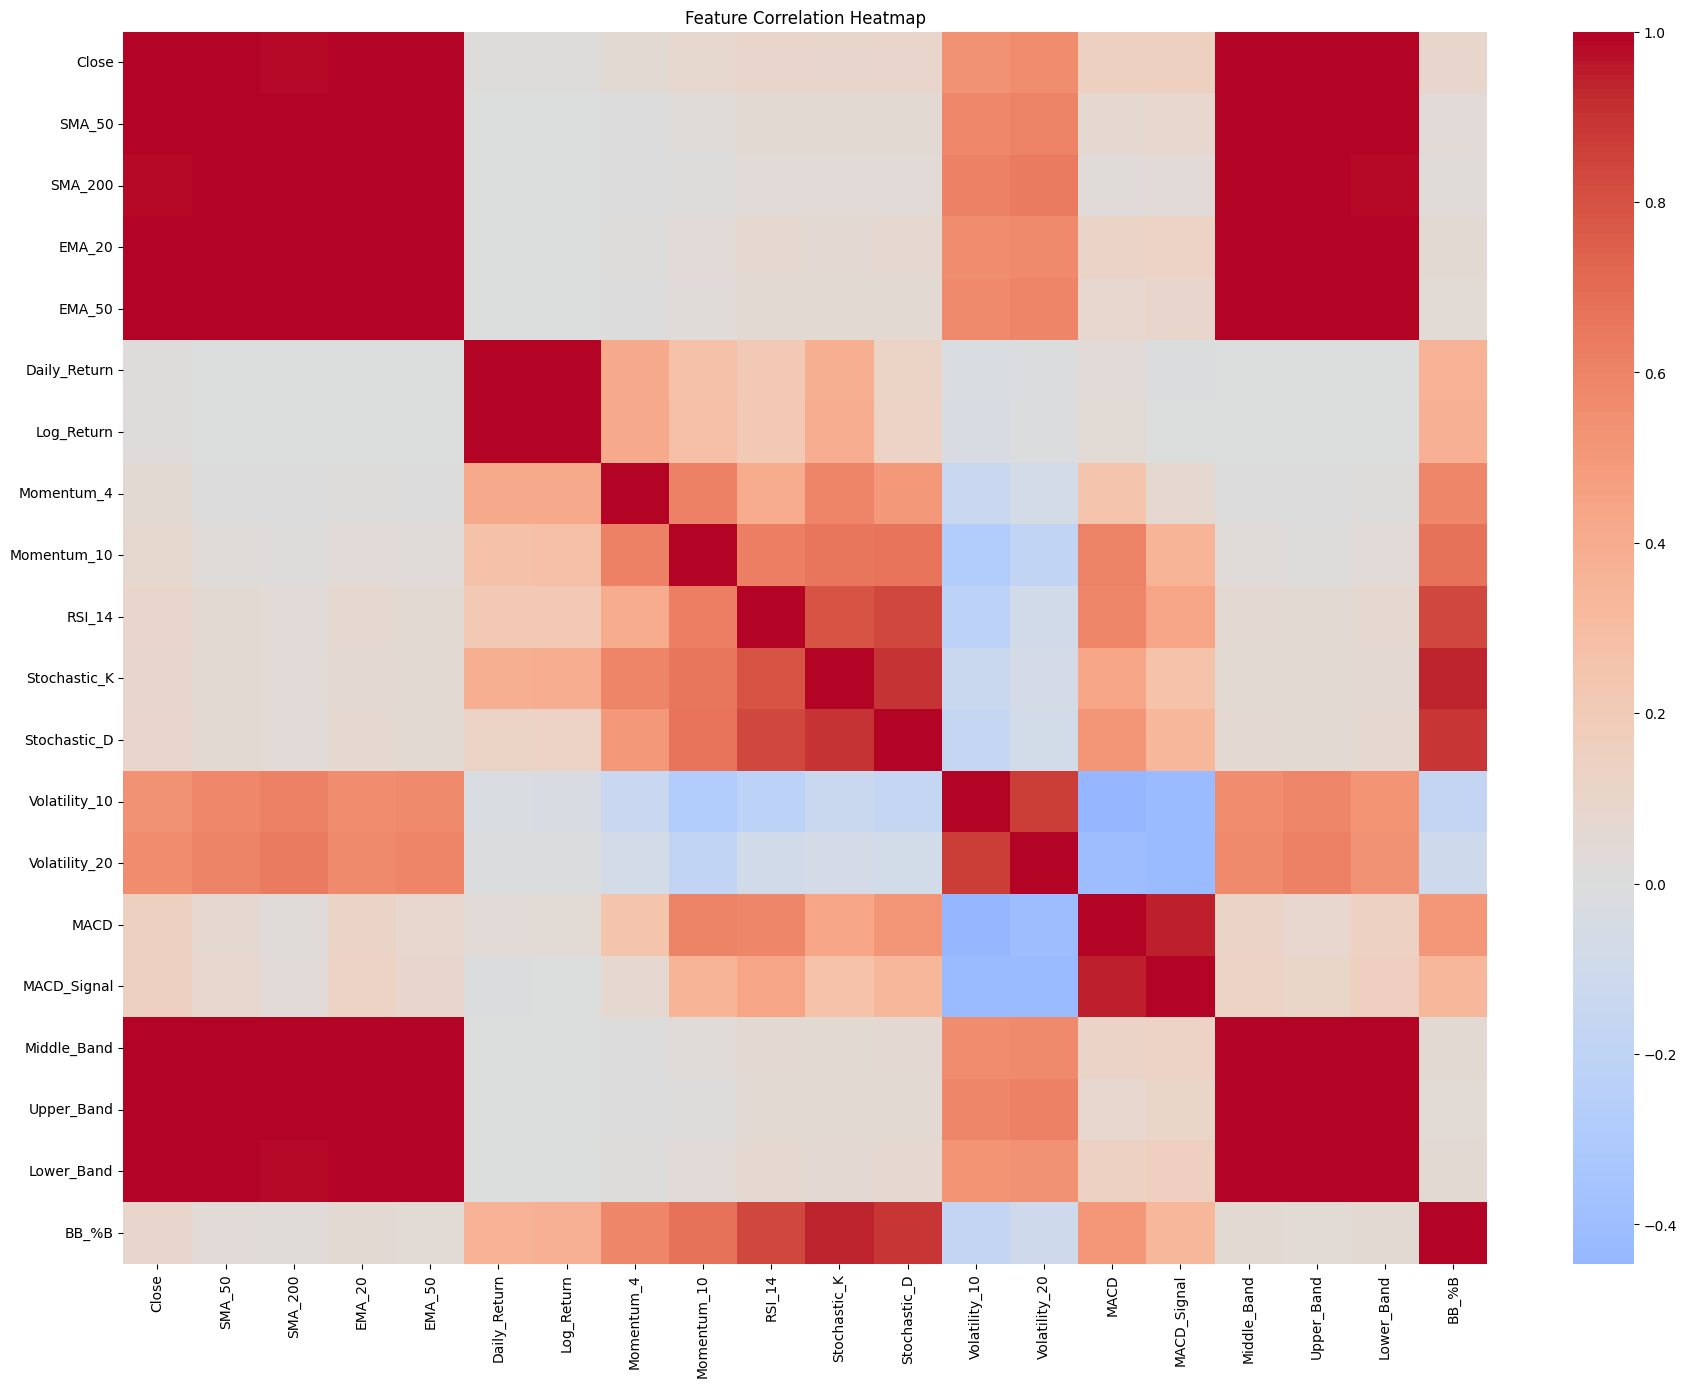

In [75]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(22, 16))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [76]:
# ===============================
# Highlighting the higly correlated features
# ===============================
FEATURE_COLS = ['Close',
                'SMA_50', 'SMA_200', 'EMA_20', 'EMA_50', 
                'Daily_Return', 'Log_Return', 'Momentum_4', 'Momentum_10',
                'RSI_14', 'Stochastic_K', 'Stochastic_D', 
                'Volatility_10', 'Volatility_20', 
                'MACD', 'MACD_Signal',
                'Middle_Band', 'Upper_Band', 'Lower_Band', 'BB_%B'
              ]

corr_matrix =X.corr().abs()
high_corr = np.where(corr_matrix > 0.95)  # threshold 0.95
high_corr_pairs = [(FEATURE_COLS[i], FEATURE_COLS[j]) for i, j in zip(*high_corr) if i != j and i < j]
print("Highly correlated pairs:", high_corr_pairs)

Highly correlated pairs: [('Close', 'SMA_50'), ('Close', 'SMA_200'), ('Close', 'EMA_20'), ('Close', 'EMA_50'), ('Close', 'Middle_Band'), ('Close', 'Upper_Band'), ('Close', 'Lower_Band'), ('SMA_50', 'SMA_200'), ('SMA_50', 'EMA_20'), ('SMA_50', 'EMA_50'), ('SMA_50', 'Middle_Band'), ('SMA_50', 'Upper_Band'), ('SMA_50', 'Lower_Band'), ('SMA_200', 'EMA_20'), ('SMA_200', 'EMA_50'), ('SMA_200', 'Middle_Band'), ('SMA_200', 'Upper_Band'), ('SMA_200', 'Lower_Band'), ('EMA_20', 'EMA_50'), ('EMA_20', 'Middle_Band'), ('EMA_20', 'Upper_Band'), ('EMA_20', 'Lower_Band'), ('EMA_50', 'Middle_Band'), ('EMA_50', 'Upper_Band'), ('EMA_50', 'Lower_Band'), ('Daily_Return', 'Log_Return'), ('Middle_Band', 'Upper_Band'), ('Middle_Band', 'Lower_Band'), ('Upper_Band', 'Lower_Band')]


In [77]:
# ===============================
# Removing those that contains the same information
# ===============================
df_ml = df_ml.drop(columns=['SMA_200', 'EMA_50',
                            'Volatility_20',
                            'MACD',
                            'Middle_Band', 'Lower_Band'
                            ])

In [78]:
# ===============================
# Prepare features and target variable for correlation heatmap
# ===============================
X = df_ml.drop(columns=["Date"], errors="ignore") # Features
y = df_ml["Close"] 

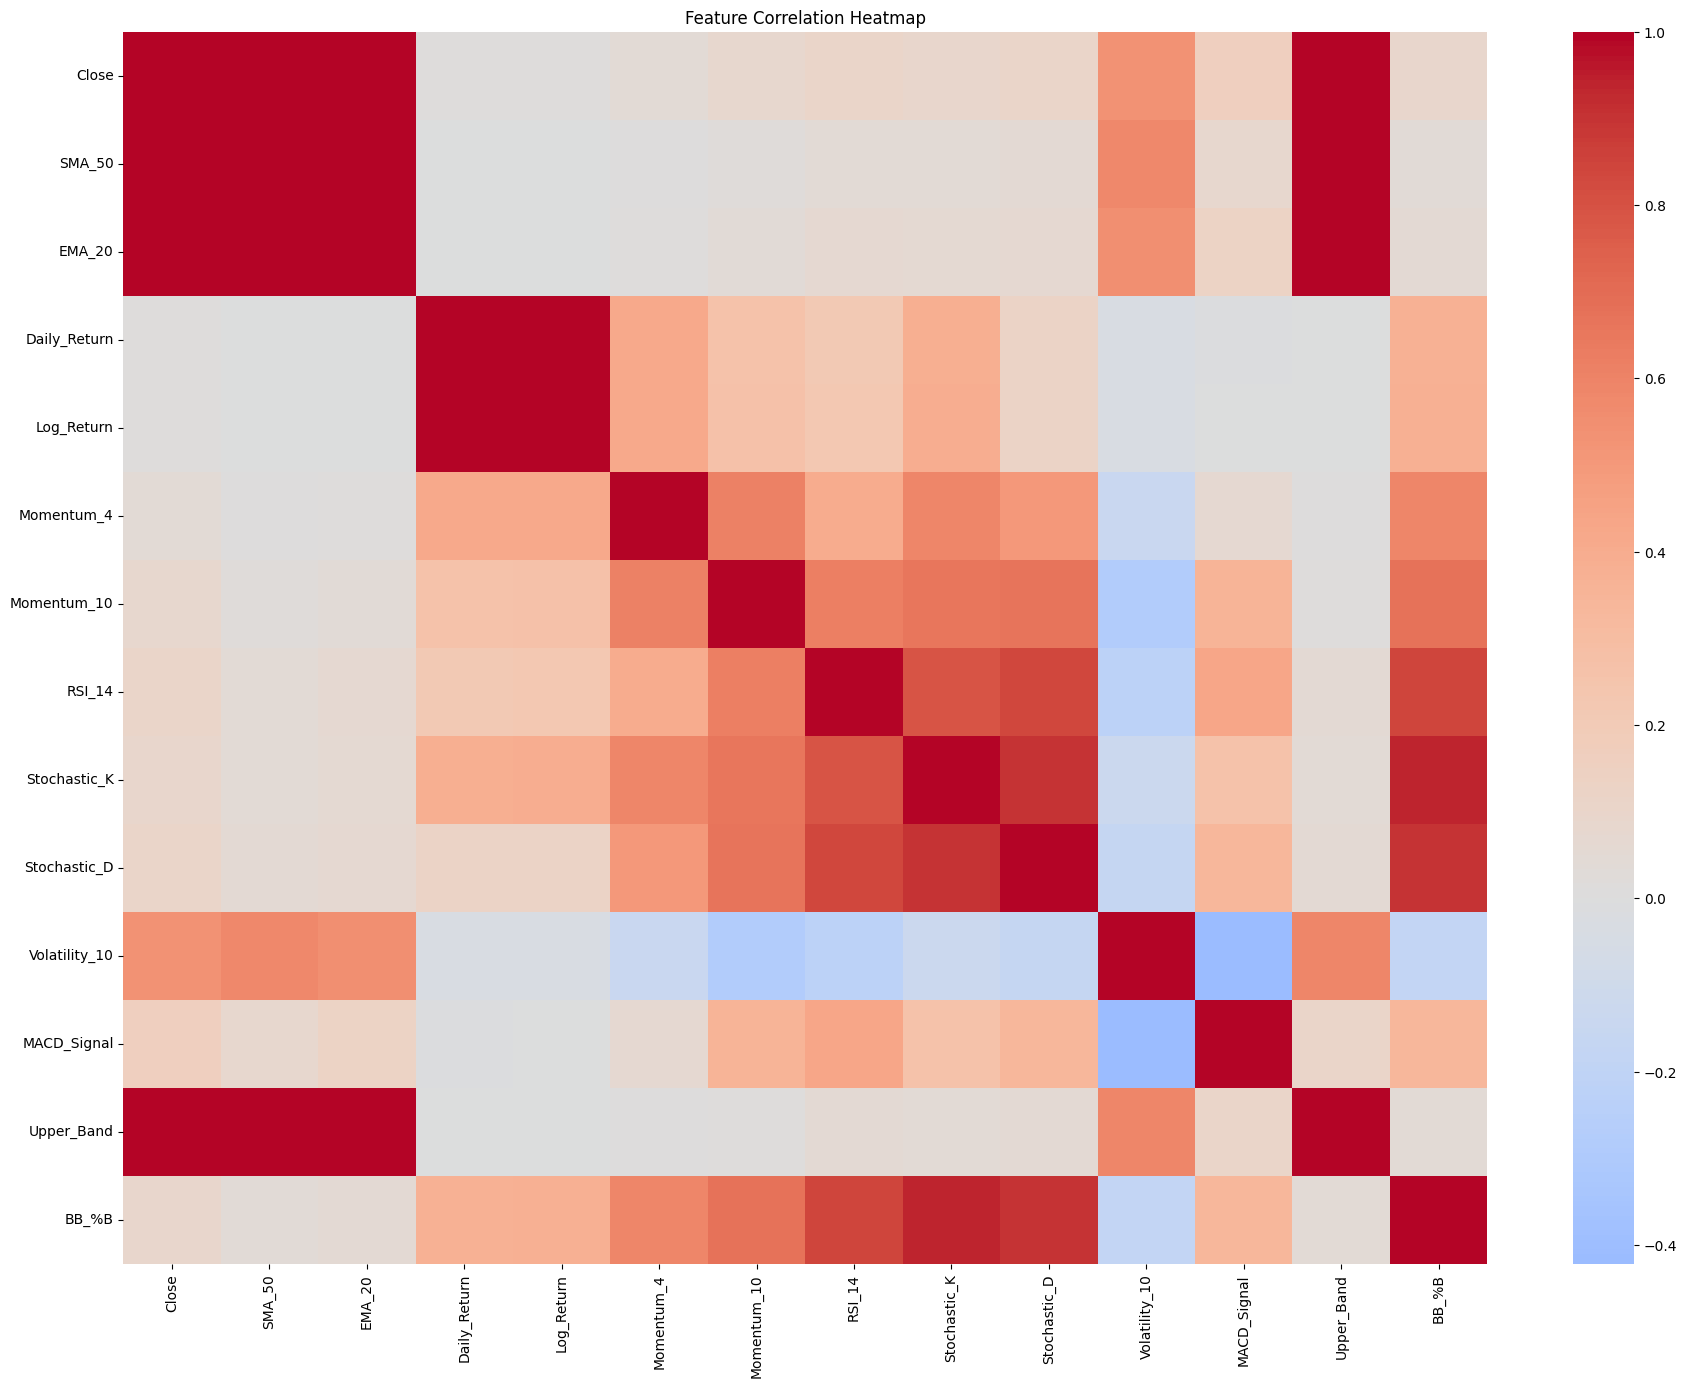

In [79]:
# ===============================
# Correlation Heatmap
# ===============================
plt.figure(figsize=(22, 16))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

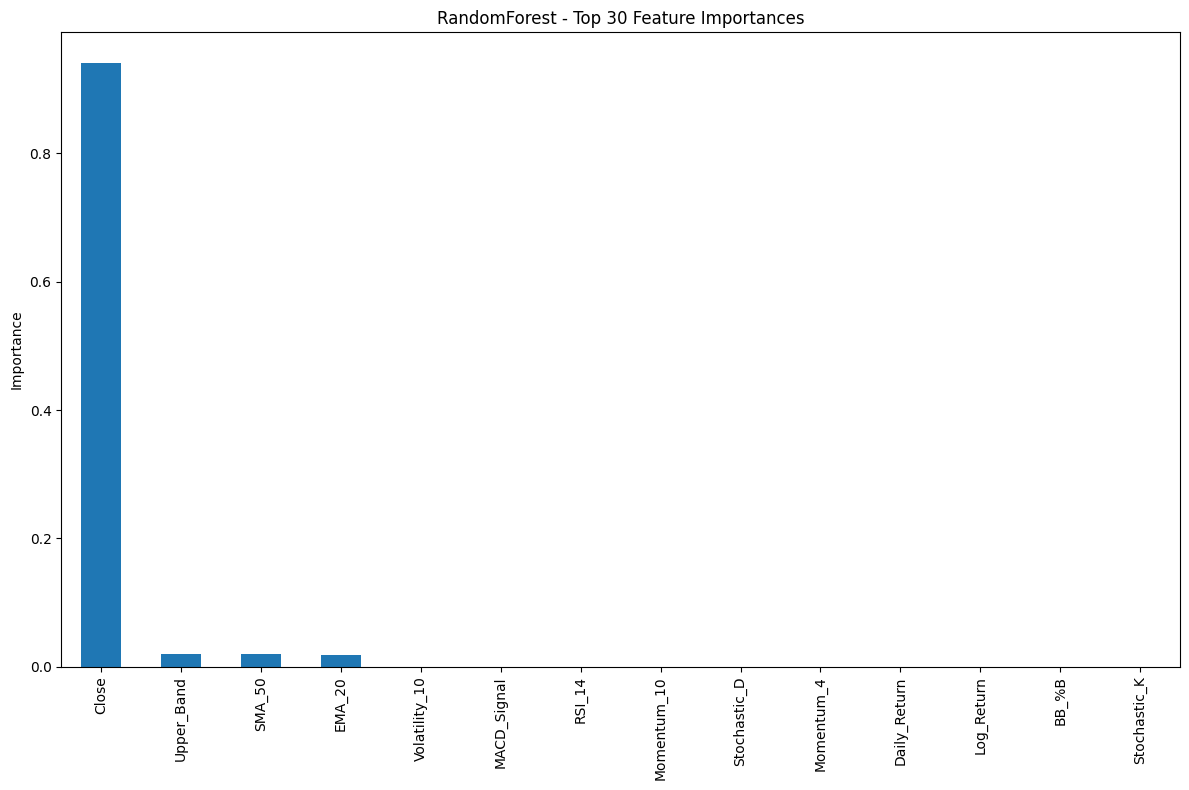

In [80]:
# ===============================
# Random Forest Feature Importances
# ===============================
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
importances.head(30).plot(kind="bar")
plt.title("RandomForest - Top 30 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

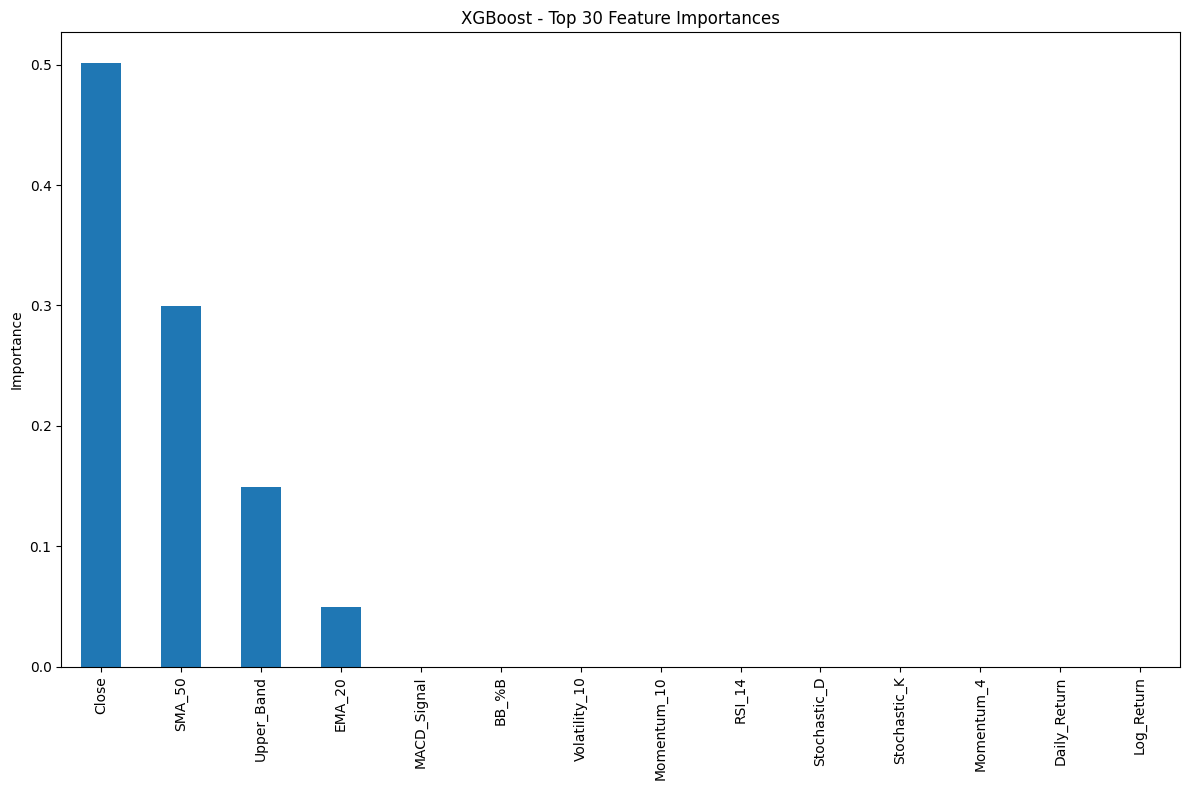

In [81]:
# ===============================
# XGBoost Feature Importances
# ===============================
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)

xgb.fit(X, y)

xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
xgb_importances.head(30).plot(kind="bar")
plt.title("XGBoost - Top 30 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

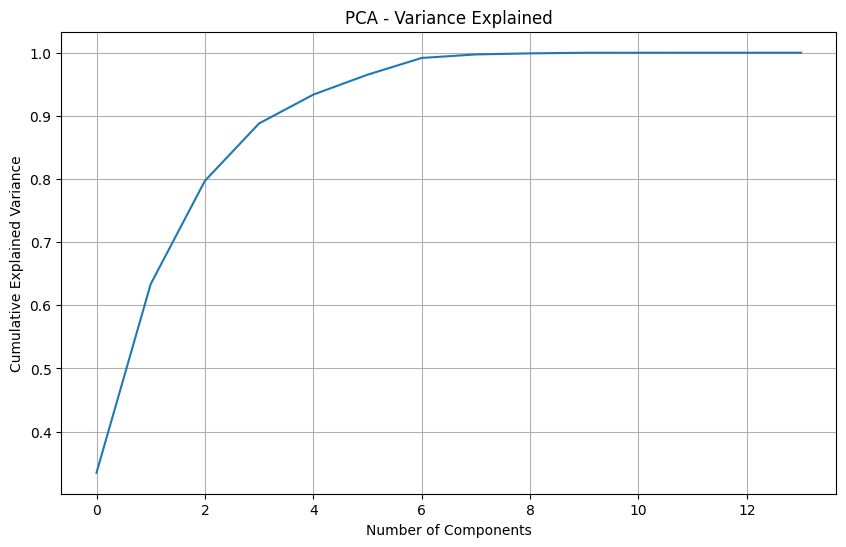

In [82]:
# ===============================
# PCA Variance Explained
# ===============================
pca = PCA()
pca.fit(X)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Variance Explained')
plt.grid(True)
plt.show()

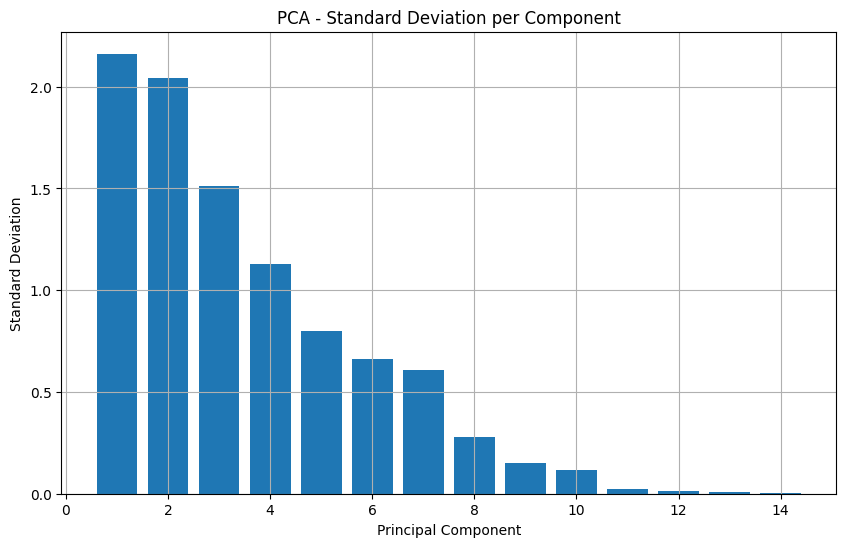

In [83]:
# ===============================
# PCA Variance Explained
# ===============================
explained_variance = pca.explained_variance_
std_dev = np.sqrt(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(std_dev) + 1), std_dev)
plt.xlabel('Principal Component')
plt.ylabel('Standard Deviation')
plt.title('PCA - Standard Deviation per Component')
plt.grid(True)
plt.show()

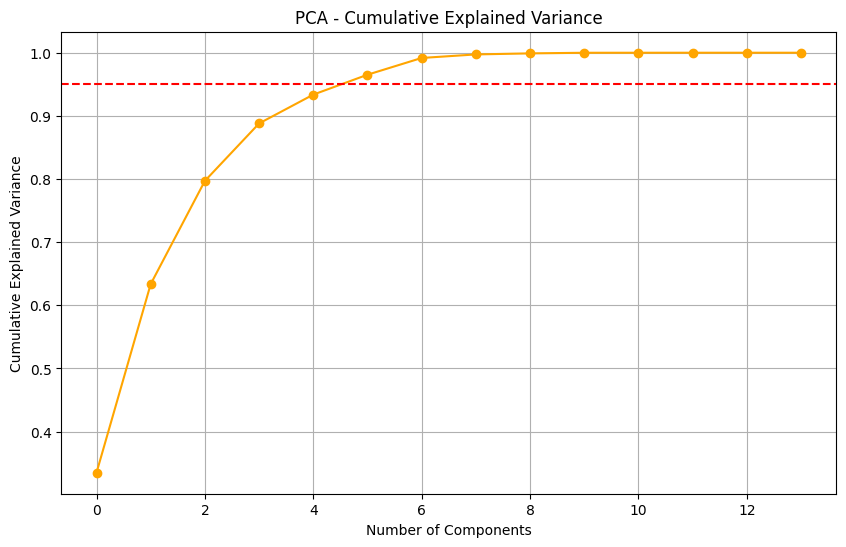

In [84]:
# ===============================
# PCA Variance Explained
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange')
plt.axhline(y=0.95, color='r', linestyle='--')  # Draw a line at 95% variance
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

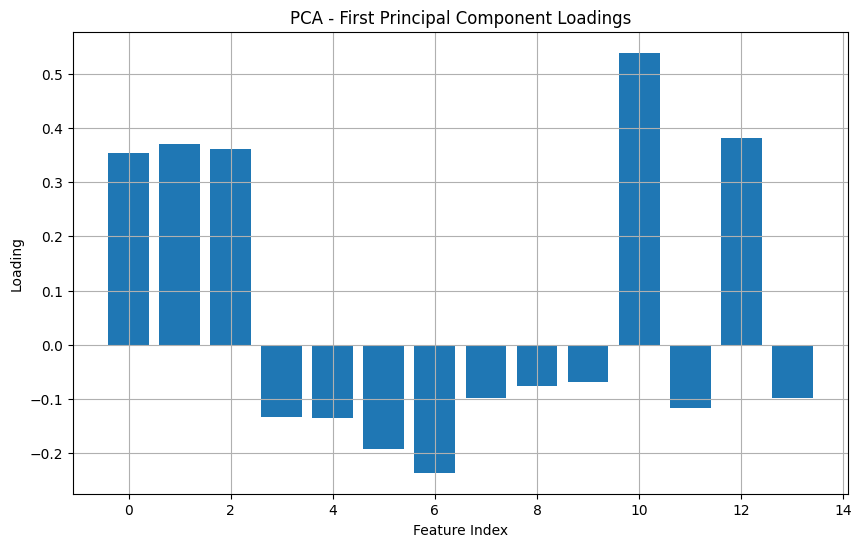

In [85]:
# ===============================
# PCA Principal components
# ===============================
components = pca.components_
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), components[0])
plt.xlabel('Feature Index')
plt.ylabel('Loading')
plt.title('PCA - First Principal Component Loadings')
plt.grid(True)
plt.show()

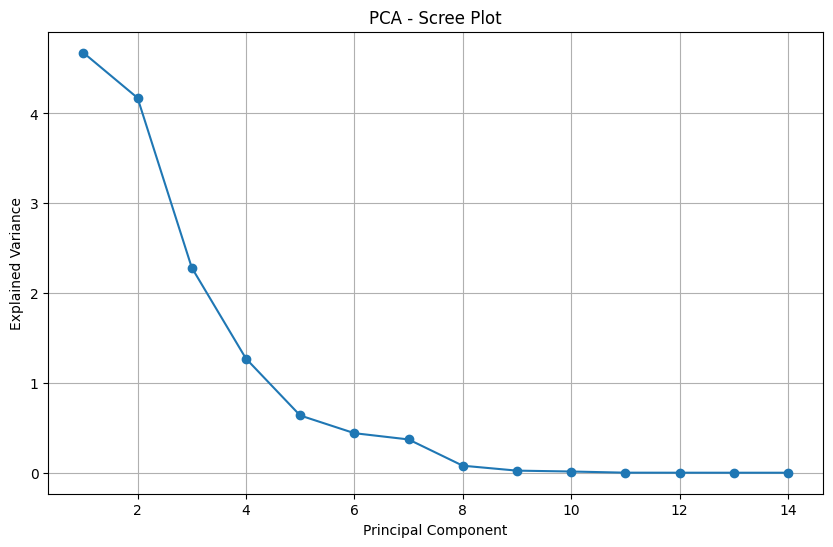

In [86]:
# ===============================
# Scree plot
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('PCA - Scree Plot')
plt.grid(True)
plt.show()

In [87]:
# ===============================
# Some hyperparameters for model training 
# ===============================
SEQ_LEN = 60           # input window (days)
PRED_HORIZON = 1       # predict 1 step ahead (next day), for multi-step, see recursive forecast
BATCH_SIZE = 64
EPOCHS = 20
VAL_SIZE = 0.1         # fraction for validation (time split used below)
TEST_SIZE = 0.1        # fraction for test (time split used below)

In [88]:
# ===============================
# Define features and targets
# ===============================
# Required inputs (assumptions)
FEATURE_COLS = ['Close', 
                'SMA_50', 'EMA_20', 
                'Daily_Return', 'Log_Return', 'Momentum_4', 'Momentum_10',
                'RSI_14', 'Stochastic_K', 'Stochastic_D', 
                'Volatility_10', 
                'MACD_Signal',
                'Upper_Band', 'BB_%B'
              ]
TARGET_INDEX = FEATURE_COLS.index('Close')

In [89]:
df_ml = df_ml.reset_index(drop=True)
df_ml

,Close,SMA_50,EMA_20,Daily_Return,Log_Return,Momentum_4,Momentum_10,RSI_14,Stochastic_K,Stochastic_D,Volatility_10,MACD_Signal,Upper_Band,BB_%B
0,-0.425974,-0.452628,-0.435356,0.147618,0.147483,-0.215946,0.252397,0.469757,0.033603,-0.011113,-0.583782,0.236402,-0.455154,0.198838
1,-0.430636,-0.452353,-0.434641,-0.476552,-0.477776,-0.252436,0.016194,0.540580,-0.215726,-0.064064,-0.683298,0.233800,-0.454858,-0.012408
2,-0.441341,-0.452457,-0.435011,-1.028018,-1.033849,-0.438425,-0.272684,0.052090,-0.669283,-0.295049,-0.613500,0.216253,-0.455039,-0.451040
3,-0.452679,-0.452602,-0.436423,-1.096969,-1.103619,-0.770920,-0.564169,-0.437380,-0.985937,-0.666366,-0.369578,0.179937,-0.454670,-0.874617
4,-0.440973,-0.452148,-0.436589,1.034299,1.028296,-0.518487,-0.493624,-0.011367,-0.567450,-0.794464,-0.344461,0.142197,-0.454667,-0.419401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6305,2.425928,2.512768,2.441083,-2.299444,-2.329167,-1.415488,1.025406,0.051426,-0.195037,0.143186,3.731308,-0.583262,2.553503,-0.133195
6306,2.385237,2.504109,2.435461,-1.005065,-1.010636,-5.052504,0.831453,0.213307,-0.658455,-0.209607,2.951787,-0.441818,2.552190,-0.313624
6307,2.437032,2.495292,2.435297,1.168220,1.160583,-2.881073,0.155608,0.096133,-0.351852,-0.423953,2.821343,-0.344876,2.555093,-0.104243
6308,2.474094,2.490132,2.438671,0.808643,0.804952,-1.461508,0.000372,0.079659,-0.132461,-0.401163,2.801025,-0.250730,2.558505,0.031611


In [90]:
# ===============================
# Some hyperparameters for model training 
# ===============================
SEQ_LEN = 60           # input window (days)
PRED_HORIZON = 1       # predict 1 step ahead (next day), for multi-step, see recursive forecast
BATCH_SIZE = 64
EPOCHS = 10
VAL_SIZE = 0.1         # fraction for validation (time split used below)
TEST_SIZE = 0.1        # fraction for test (time split used below)

In [93]:
# ===============================
# Build sequences
# ===============================
class SeqDataset(Dataset):
    def __init__(self, data, seq_length=60, prediction_length=1, feature_dim=4, target_column_idx=0):
        """
        data: numpy array of shape [num_samples, num_features]
        seq_length: how many timesteps in the input sequence
        prediction_length: how many future steps we want to predict
        feature_dim: total number of features in data (for dimension checking)
        target_column_idx: which column to use as the target (e.g., close=0)
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        # The maximum starting index is total_length - seq_length - prediction_length
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        # Input sequence
        x = self.data[idx : idx + self.seq_length]
        # Future price(s)
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    
dataset = SeqDataset(df_ml[FEATURE_COLS].values, SEQ_LEN, PRED_HORIZON, len(FEATURE_COLS), TARGET_INDEX)

In [94]:
# ===============================
# Train/validation (time-ordered)
# ===============================
# Train/Validation/Test Split
train_size = int(len(dataset) * (1 - VAL_SIZE - TEST_SIZE))
val_size = int(len(dataset) * VAL_SIZE)
test_size = len(dataset) - train_size - val_size

# Perform sequential splitting (without shuffling)
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [95]:
# ===============================
# Model definition
# ===============================
# [Input: (B, SEQ_LEN, N_FEATURES)]
#          |
#      [Linear: N_FEATURES --> 64]
#          |
# [+Positional Embedding (1, SEQ_LEN, 64)]
#          |
#      [Transformer Encoder]
#      (2 Layers, 8 Heads, FF=256)
#          |
# [Output Linear: 64 --> 1]
#          |
# [Predictions: (B, PRED_HORIZON)]


class TimeSeriesTransformer(nn.Module):
    def __init__(self,
        feature_size=9,
        num_layers=2,
        d_model=64,
        nhead=8,
        dim_feedforward=256,
        dropout=0.1,
        seq_length=30,
        prediction_length=1
    ):
        super(TimeSeriesTransformer, self).__init__()

        # We'll embed each feature vector (feature_size) into a d_model-sized vector
        self.input_fc = nn.Linear(feature_size, d_model)

        # Positional Encoding (simple learnable or sinusoidal): learnable here:
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu", 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final output: we want to forecast `prediction_length` steps for 1 dimension (Close price)
        # (adjust for multi-step and multi-dimensional ...)
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        """
        src shape: [batch_size, seq_length, feature_size]
        """
        
        batch_size, seq_len, _ = src.shape
        if seq_len > self.pos_embedding.size(1):
            raise RuntimeError(
                f"seq_len={seq_len} exceeds max positional length={self.pos_embedding.size(1)}"
            )


        # First project features into d_model
        src = self.input_fc(src)  # -> [batch_size, seq_length, d_model]

        # Add positional embedding
        # pos_embedding -> [1, seq_length, d_model], so broadcast along batch dimension
        src = src + self.pos_embedding[:, :seq_len, :]

        # Pass through the transformer
        encoded = self.transformer_encoder(src)  # [batch_size, seq_length, d_model]

        # We only want the output at the last time step for forecasting the future
        last_step = encoded[: , -1, :]  # [batch_size, d_model]

        out = self.fc_out(last_step)  # [batch_size, prediction_length]
        return out
    

model = TimeSeriesTransformer(
    feature_size=len(FEATURE_COLS),
    num_layers=2,
    d_model=64,
    nhead=8,
    dim_feedforward=256,
    dropout=0.1,
    seq_length=SEQ_LEN,
    prediction_length=PRED_HORIZON
)
device = torch.device("cpu")
torch.set_num_threads(1)   # extra safety on macOS

In [96]:
print(model)

TimeSeriesTransformer(
  (input_fc): Linear(in_features=14, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


In [97]:
# ===============================
# Training
# ===============================
def train_model(
    model, device,
    train_loader, val_loader,
    epochs=10, learning_rate=1e-3, patience=5,
    max_grad_norm=1.0, scheduler_step=10, scheduler_gamma=0.5,
    print_every=1, verbose=True
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

    model = model.to(device)

    best_val_loss = float("inf")
    best_model_state = copy.deepcopy(model.state_dict())
    patience_counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "lr": []
    }

    for epoch in range(1, epochs + 1):

        # Training
        model.train()
        train_losses = []

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            optimizer.zero_grad()

            output = model(x_batch)
            loss = criterion(output, y_batch)

            # NaN / Inf guard
            if not torch.isfinite(loss):
                print("Skipping batch due to NaN/Inf loss")
                continue

            loss.backward()

            # Gradient clipping (VERY important for Transformers)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.float().to(device)
                y_val = y_val.float().to(device)

                output_val = model(x_val)
                loss_val = criterion(output_val, y_val)

                if torch.isfinite(loss_val):
                    val_losses.append(loss_val.item())

        mean_val_loss = np.mean(val_losses)

        # Scheduler
        scheduler.step()

        # Logging
        history["train_loss"].append(mean_train_loss)
        history["val_loss"].append(mean_val_loss)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if verbose and epoch % print_every == 0:
            print(f"Epoch [{epoch}/{epochs}] | Train: {mean_train_loss:.6f} | Val: {mean_val_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Early stopping 
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch} (best val loss: {best_val_loss:.6f})")
            break

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, history

In [98]:
trained_model, history = train_model(
    model=model, device=device,
    train_loader=train_loader, val_loader=val_loader,
    epochs=EPOCHS, learning_rate=1e-3, patience=5,
    max_grad_norm=1.0, scheduler_step=10, scheduler_gamma=0.5,
    print_every=1, verbose=True
)

Epoch [1/10] | Train: 0.107091 | Val: 0.613943 | LR: 1.00e-03


Epoch [2/10] | Train: 0.106823 | Val: 0.231466 | LR: 1.00e-03


Epoch [3/10] | Train: 0.102055 | Val: 0.078537 | LR: 1.00e-03


Epoch [4/10] | Train: 0.098973 | Val: 0.112191 | LR: 1.00e-03


Epoch [5/10] | Train: 0.199434 | Val: 0.328921 | LR: 1.00e-03


Epoch [6/10] | Train: 0.064815 | Val: 0.041586 | LR: 1.00e-03


Epoch [7/10] | Train: 0.064628 | Val: 0.089472 | LR: 1.00e-03


Epoch [8/10] | Train: 0.030319 | Val: 0.074145 | LR: 1.00e-03


Epoch [9/10] | Train: 0.023373 | Val: 0.103331 | LR: 1.00e-03


Epoch [10/10] | Train: 0.017419 | Val: 0.029383 | LR: 5.00e-04


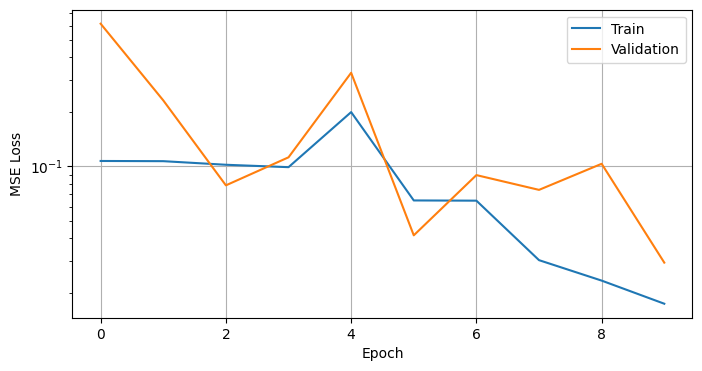

In [99]:
# ===============================
# Plot training loss & metrics
# ===============================
plt.figure(figsize=(8, 4))
plt.plot(history["train_loss"], label="Train")
plt.plot(history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [102]:
# ===============================
# Evaluate / Predictions (test)
# ===============================
# Predict (scaled)
def predict_model(model, dataloader, device, scaler, feature_cols, target_col_idx, pred_length):
    model.eval()
    all_preds = []
    all_trues = []
    n_features = len(feature_cols)

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            # Model output: (B, pred_length)
            preds = model(x_batch)
            preds = preds.cpu().numpy()
            trues = y_batch.cpu().numpy()
            B = preds.shape[0]

            # Vectorized inverse scaling
            dummy_pred = np.zeros((B * pred_length, n_features))
            dummy_true = np.zeros((B * pred_length, n_features))

            dummy_pred[:, target_col_idx] = preds.reshape(-1)
            dummy_true[:, target_col_idx] = trues.reshape(-1)

            inv_pred = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
            inv_true = scaler.inverse_transform(dummy_true)[:, target_col_idx]

            all_preds.append(inv_pred)
            all_trues.append(inv_true)

    predicted_prices = np.concatenate(all_preds)
    real_prices = np.concatenate(all_trues)

    return real_prices, predicted_prices


real_test, pred_test = predict_model(
    model=trained_model,
    dataloader=test_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)

In [103]:
# ===============================
# Evaluate / Predictions (compute metrics)
# ===============================
def compute_metrics(true, pred):
    true = np.asarray(true).reshape(-1)
    pred = np.asarray(pred).reshape(-1)

    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred) ** 2)
    rmse = np.sqrt(mse)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


metrics_test = compute_metrics(real_test, pred_test) # (on original units)
print("Test metrics:", metrics_test)

Test metrics: {'MAE': 1077.1369462774678, 'MSE': 1289388.0789407513, 'RMSE': 1135.5122539808856}


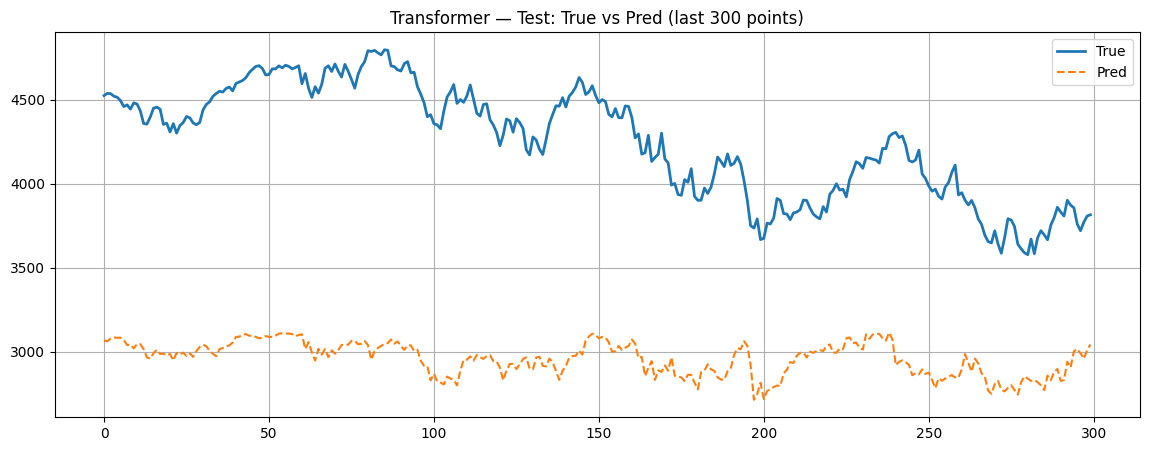

In [104]:
# ===============================
# Plot predictions vs true prices
# ===============================
Nplot = min(300, len(real_test))

plt.figure(figsize=(14, 5))
plt.plot(real_test[-Nplot:], label="True", linewidth=2)
plt.plot(pred_test[-Nplot:], label="Pred", linestyle="--")
plt.legend()
plt.grid(True)
plt.title(f"Transformer — Test: True vs Pred (last {Nplot} points)")
plt.show()

Train size: [ 927.69000088  939.21002762  952.1200084  ... 2585.63985092 2578.85005195
 2582.13983915]


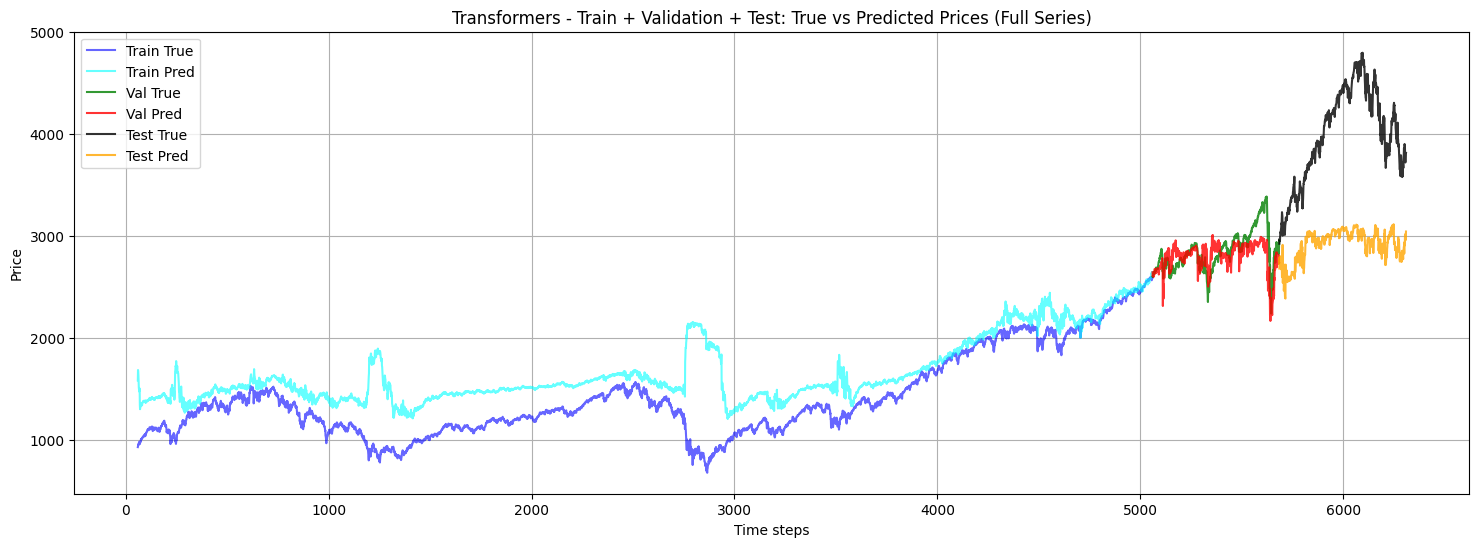

Training metrics (original units): {'MAE': 252.74533381437962, 'MSE': 115254.26525766755, 'RMSE': 339.4911858320736}
Validation metrics (original units): {'MAE': 124.86609843452757, 'MSE': 27739.3358919958, 'RMSE': 166.55130108166614}
Test metrics (original units): {'MAE': 1077.1369462774678, 'MSE': 1289388.0789407513, 'RMSE': 1135.5122539808856}


In [ ]:
# ===============================
# Full series plot - Train + Validation + Test
# ===============================
# Predict scaled values for train and validation
real_train, pred_train = predict_model(
    model=trained_model,
    dataloader=train_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)
real_val, pred_val = predict_model(
    model=trained_model,
    dataloader=val_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)

train_offset = SEQ_LEN
val_offset   = SEQ_LEN + len(real_train)
test_offset  = SEQ_LEN + len(real_train) + len(real_val)

# Plot the full series
plt.figure(figsize=(18,6))
plt.plot(range(train_offset, train_offset+len(real_train)), real_train, label="Train True", color='blue', alpha=0.6)
plt.plot(range(train_offset, train_offset+len(real_train)), pred_train, label="Train Pred", color='cyan', alpha=0.6)
plt.plot(range(val_offset, val_offset+len(real_val)), real_val, label="Val True", color='green', alpha=0.8)
plt.plot(range(val_offset, val_offset+len(real_val)), pred_val, label="Val Pred", color='red', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), real_test, label="Test True", color='black', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), pred_test, label="Test Pred", color='orange', alpha=0.8)
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.title("Transformers - Train + Validation + Test: True vs Predicted Prices (Full Series)")
plt.legend()
plt.grid(True)
plt.show()

# Compute metrics (on original units)
def compute_metrics(true, pred):
    true = np.array(true).reshape(-1)
    pred = np.array(pred).reshape(-1)
    mae = np.mean(np.abs(true - pred))
    mse = np.mean((true - pred)**2)
    rmse_v = np.sqrt(mse)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse_v}

metrics_train = compute_metrics(real_train, pred_train)
metrics_val = compute_metrics(real_val, pred_val)
metrics_test = compute_metrics(real_test, pred_test)

print("Training metrics (original units):", metrics_train)
print("Validation metrics (original units):", metrics_val)
print("Test metrics (original units):", metrics_test)

In [109]:
# ===============================
# Recursive multi-step forecast (future) by re-updating features at each step
# ===============================
def scale_features_row(df_row):
    df_scaled = df_row.copy()
    # Close
    df_scaled["Close"] = close_scaler.transform(df_row[["Close"]])
    # Price features
    df_scaled[price_cols] = prices_scaler.transform(df_row[price_cols])
    # Indicators
    for col, scaler in indicators_scalers.items():
        df_scaled[col] = scaler.transform(df_row[[col]])
    return df_scaled

def recursive_forecast_seq2seq(
    model,
    df_history,          
    last_enc_seq,       
    n_steps=200,
):
    model.eval()
    enc_seq = last_enc_seq.copy()
    df_hist = df_history.copy()
    preds = []

    for _ in range(n_steps):
        # Predict next Close (scaled)
        enc_tensor = torch.tensor(enc_seq[np.newaxis, ...], dtype=torch.float32, device=device)
        with torch.no_grad():
            pred_scaled = model(enc_tensor)  # [1, pred_length]
            pred_scaled = pred_scaled.cpu().numpy()[0, 0]

        # Inverse scale Close
        pred_close = close_scaler.inverse_transform([[pred_scaled]])[0, 0]
        preds.append(pred_close)

        # Build next RAW row (OHLCV logic)
        last_row = df_hist.iloc[-1].copy()
        new_row = last_row.copy()
        new_row["Close"] = pred_close

        # 4. Append & recompute ALL features
        df_hist = df_history.copy()
        df_hist = pd.concat([df_hist, new_row.to_frame().T], ignore_index=True)
        df_hist = preprocess_data(df_hist)
        df_hist = df_hist.select_dtypes(include=[np.number]).dropna()
        df_hist = df_hist.replace([np.inf, -np.inf], np.nan)
        df_hist = df_hist.dropna()

        # 5. Take last row & scale it correctly
        df_scaled = scale_features_row(df_hist)
        last_features_scaled = df_scaled.iloc[-1:][FEATURE_COLS]

        # 6. ENCODER lide window
        enc_seq = np.vstack([enc_seq[1:], last_features_scaled.values])

    return np.array(preds)

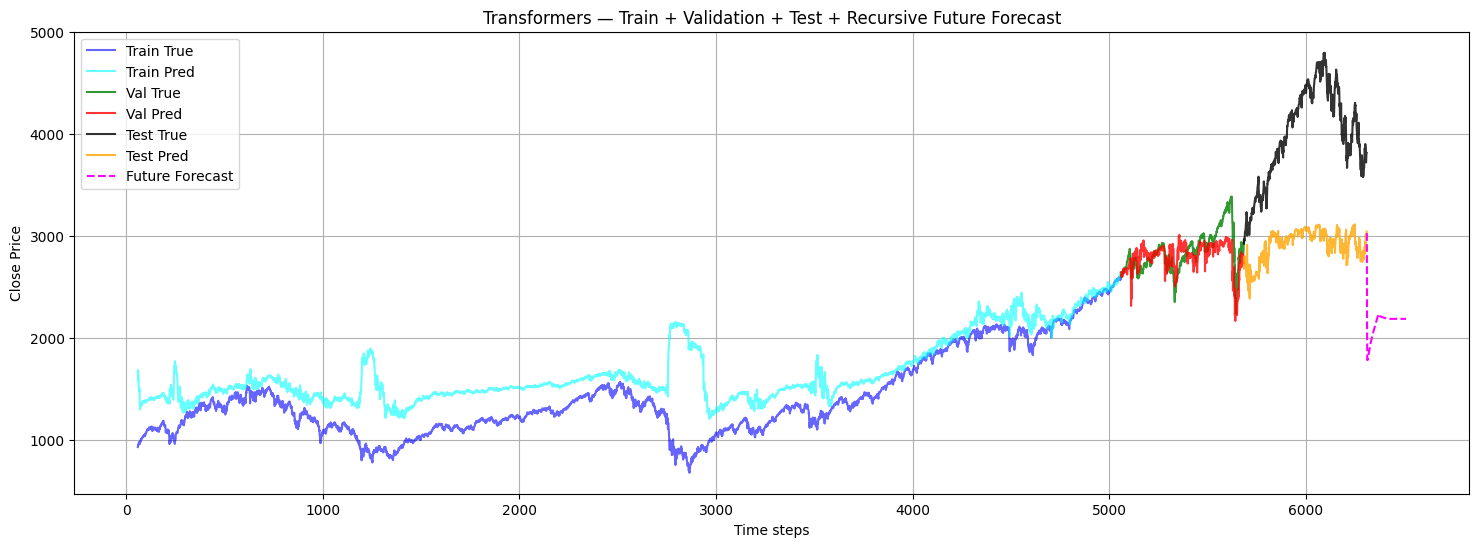

In [113]:
# ===============================
# Recursive multi-step forecast (future) by re-updating features at each step
# ===============================
# future forecast
N_FUTURE = 200
future_preds = recursive_forecast_seq2seq(
    model=model,
    df_history=df_raw_hist,
    last_enc_seq=df_ml[FEATURE_COLS].values[-SEQ_LEN:],
    n_steps=N_FUTURE
)

# Predict scaled values
real_train, pred_train = predict_model(
    model=trained_model,
    dataloader=train_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)
real_val, pred_val = predict_model(
    model=trained_model,
    dataloader=val_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)
real_test, pred_test = predict_model(
    model=trained_model,
    dataloader=test_loader,
    device=device,
    scaler=close_scaler,
    feature_cols=FEATURE_COLS,
    target_col_idx=TARGET_INDEX,
    pred_length=PRED_HORIZON
)


train_offset = SEQ_LEN
val_offset   = SEQ_LEN + len(real_train)
test_offset  = SEQ_LEN + len(real_train) + len(real_val)

# Plot the full series
plt.figure(figsize=(18,6))
plt.plot(range(train_offset, train_offset+len(real_train)), real_train, label="Train True", color='blue', alpha=0.6)
plt.plot(range(train_offset, train_offset+len(real_train)), pred_train, label="Train Pred", color='cyan', alpha=0.6)
plt.plot(range(val_offset, val_offset+len(real_val)), real_val, label="Val True", color='green', alpha=0.8)
plt.plot(range(val_offset, val_offset+len(real_val)), pred_val, label="Val Pred", color='red', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), real_test, label="Test True", color='black', alpha=0.8)
plt.plot(range(test_offset, test_offset+len(real_test)), pred_test, label="Test Pred", color='orange', alpha=0.8)
plt.plot(range(test_offset + len(real_test), test_offset + len(real_test) + N_FUTURE), future_preds, label="Future Forecast", color='magenta', linestyle='--')
plt.xlabel("Time steps")
plt.ylabel("Close Price")
plt.title("Transformers — Train + Validation + Test + Recursive Future Forecast")
plt.legend()
plt.grid(True)
plt.show()